# __Assigning fracture transmissivities__

### Problem statement

Fracture transmissivity $T_f$ [$m^2/s$] is a hydraulic property defined as the ability for a fracture to let a fluid flow. By default, we assume that the transmissivity is correlated to the fracture aperture $a$ with the cubic law:
$T_f\propto\frac{a^3}{12}$
<br>
We will see how to assign a transmissivity value and to generate transmissivities from a statistical model.

<center>
<div>
<img src="https://gitlab.com/fractorylab/dfnlab/-/raw/master/Tutorials/img/transmissivities.png" width="800"/>
</div>
<br>
Fracture transmissivities
</center>

### Theoretical background

Basic knowledge of statistical distributions and Correlated Random Fields (CRFs) is required for the generation of stochastic transmissivities.

### What will you learn ?

Assign various types of transmissivites to the fractures of a DFN:
- constant
- correlated to the fracture size
- in-plane variable transmissivities
- in-plane fracture sealing

### DFN.Lab model

The required module is __MaterialProperties__.

In [2]:
import dfnlab.MaterialProperties as mat

_____________

First, we create a system made of a cubic domain and the DFN from "Ktest.disk" file.

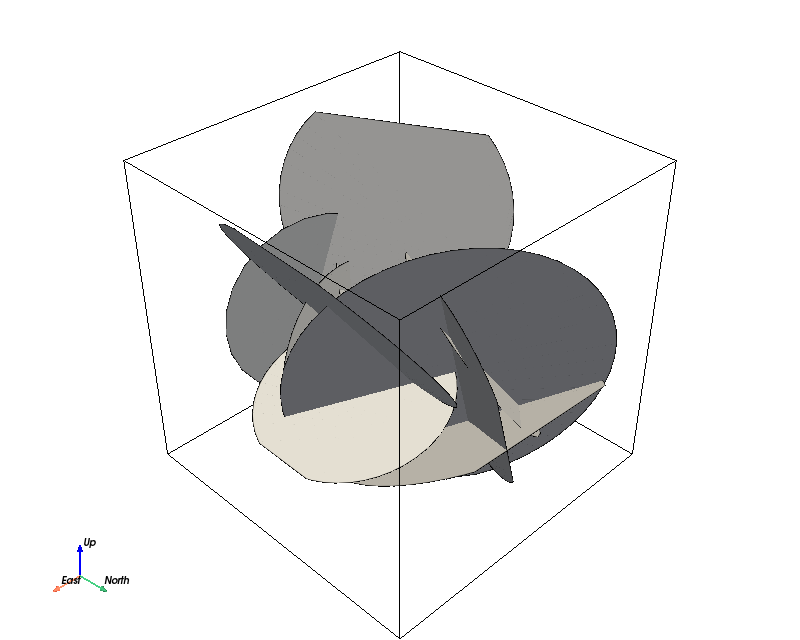

In [3]:
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn

system = sys.System()
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=1.)
system.setDomain(domain)
fnet = dfn.DFN()
system.setDFN(fnet)
dfn.load_disk_file(fnet,filename='sources/Ktest.disk')
system.build()

from sources.functions import plot_dfn
plot_dfn(system)

## Example 1: constant transmissivities

You can set a constant transmissivity for all fractures in the network.

In [4]:
transmissivities = mat.DFNProperties(fnet)
transmissivities.setConstant(1)
fnet.addProperties("transmissivities", transmissivities)

You can also use the built-in quick function:

In [5]:
mat.Transmissivities.setConstant(dfn=fnet,value=1)

Visualisation.

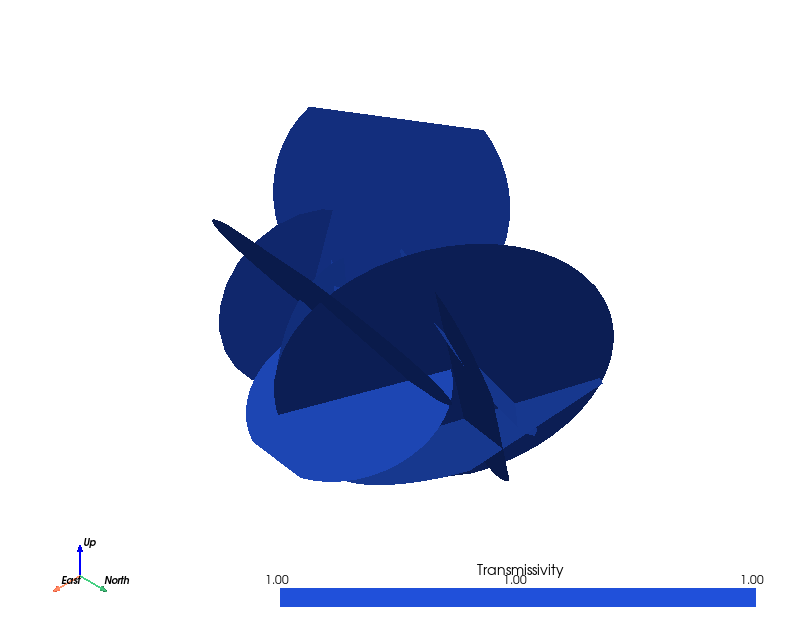

In [6]:
from sources.functions import plot_dfn_hydro
plot_dfn_hydro(system)

## Example 2: transmissivities correlated to the fracture size

You can assign, for each fracture a transmissivity following the equation:
$$\log(T_f)=\log(\eta)+\beta.\log(\frac{l_f}{2})+\sigma.U[0,1]$$
with $T_f$ the fracture transmissivity, $l_f$ the fracture size, $\sigma$ the standard deviation of the additional random noise, $\eta$ and $\beta$ the parameters of the power-law relationship between fracture size and transmissivity and are referred to $a$ and $b$ in the *setSizeCorrelated* function.

In [7]:
transmissivities = mat.DFNProperties(dfn=fnet, seed=1001)
transmissivities.setSizeCorrelated(a=1, b=2, std=0.1)
fnet.addProperties("transmissivities", transmissivities)

You can also use the built-in quick function:

In [8]:
mat.Transmissivities.setSizeCorrelated(dfn=fnet, a=1, b=2, std=0.1, seed=1001)

Visualisation.

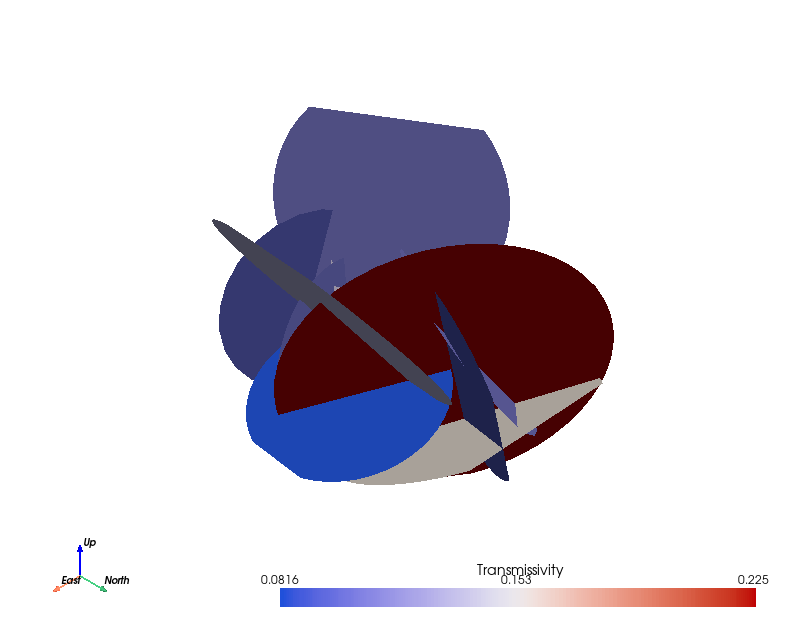

In [9]:
plot_dfn_hydro(system)

## Example 3: in-plane heterogeneous transmissivities

n addition to generating fracture networks, UFM DFN offers the flexibility to define in-plane heterogeneous transmissivities using correlated random fields.

For this purpose, we utilize a 2D correlated multivariate Gaussian field denoted as $MG(\mu, SD, \lambda_x, \lambda_y)$. This field incorporates two correlation lengths, $\lambda_x$ and $\lambda_y$, which are aligned and perpendicular to the dip direction, respectively. The parameters $\mu$ and $SD$ represent the mean and standard deviation of the Gaussian field, respectively.

To discretize the fracture surface, we employ an underlying 2D grid with a user-defined parameter called $step$. It is recommended to choose a small value relative to the fracture size $l_f$ to ensure accurate discretization of the correlation. Typically, a value around $l_f$/20 is empirically suggested for obtaining reliable results.


In [10]:
transmissivities = mat.DFNProperties(fnet)
transmissivities.setCRFGaussian(step=0.01, mean=1., std=0.3, l=0.05, ly=0.1)
fnet.addProperties("transmissivities", transmissivities)

Visualisation.

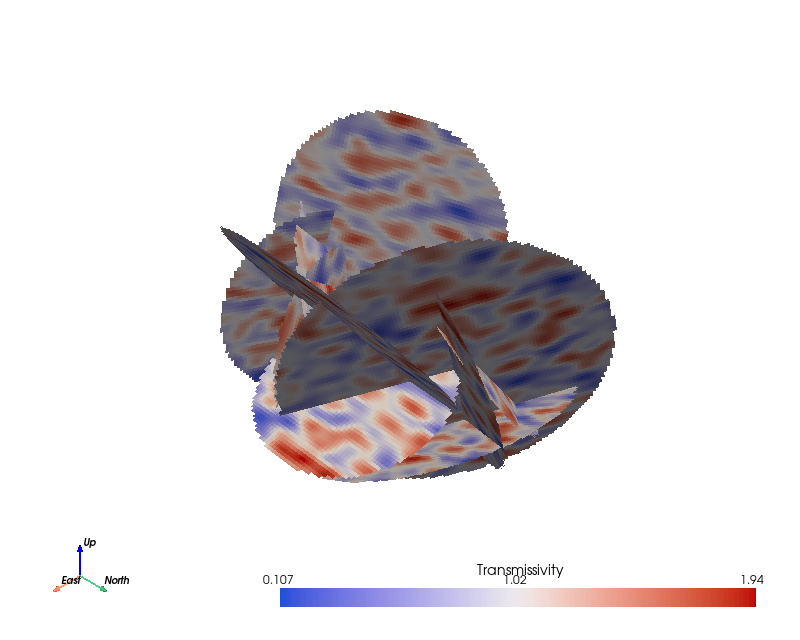

In [11]:
plot_dfn_hydro(system)

## Example 4: transmissivity with sealed patches

You can also apply a threshold to the transmissivities to account for in plane fracture sealing.
<br>
In this example, we the same correlated random field as in the previous example and use it to keep 40% of the fracture area opened (60% is sealed). In addition, with the function *setThresholdingSizeCorrelated*, the opened patches have a transmissivity correlated with the fracture size as a previous example of this tutorial.

In [12]:
transmissivities = mat.DFNProperties(fnet)
transmissivities.setCRFGaussian(step=0.01, mean=1., std=0.3, l=0.05, ly=0.1)
transmissivities.setThresholdingSizeCorrelated(ratio=0.4,a=1,b=3,std=0.1,vmin=0.)
fnet.addProperties("transmissivities", transmissivities)

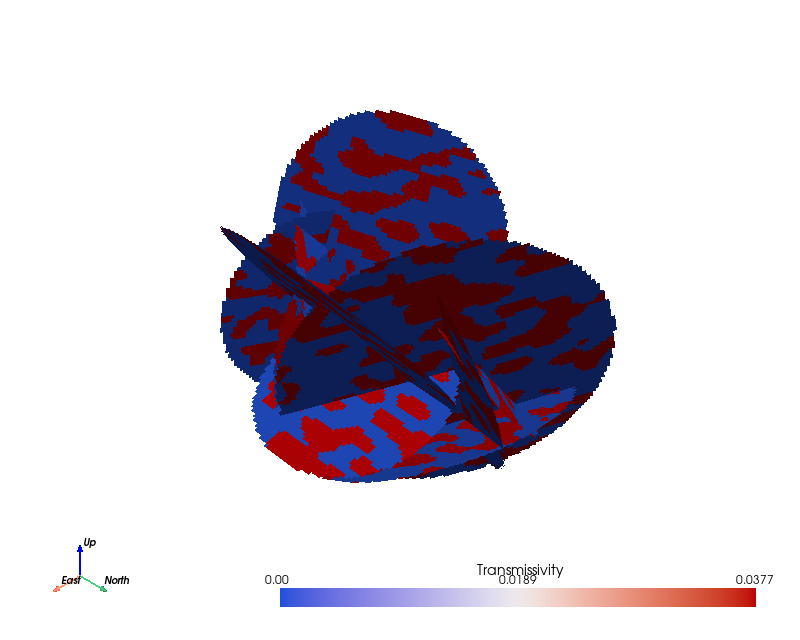

In [13]:
plot_dfn_hydro(system)

## Example 5: user-defined transmissivities

In this example, we loop over all the fractures of the DFN and assign a random transmissivity. 

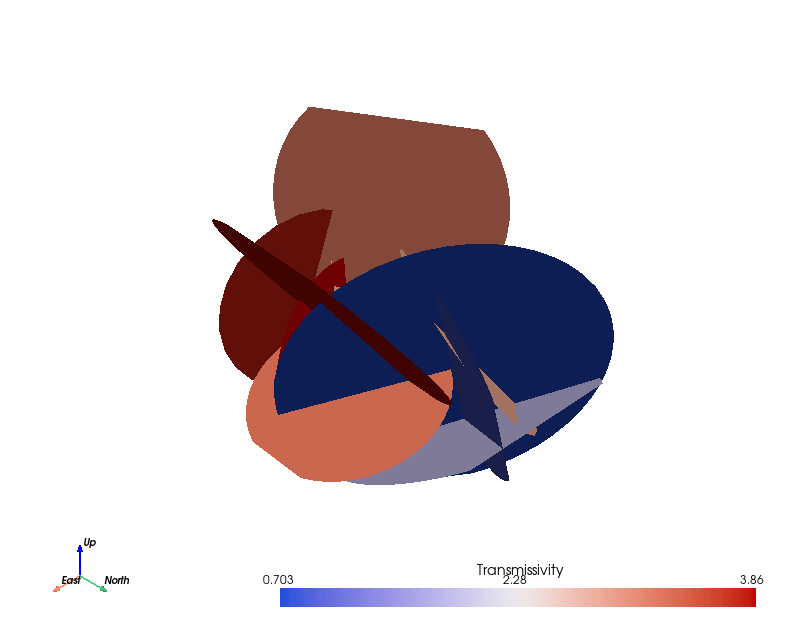

In [14]:
import random
import dfnlab.ObjectProperties as op

transmissivities = mat.DFNProperties(fnet)
for frac in fnet:
    trans = op.ObjectProperty(random.uniform(0, 5))
    transmissivities.setProperty(frac,trans)
fnet.addProperties("transmissivities", transmissivities)
plot_dfn_hydro(system)

## Example 6: user-defined transmissivities (advanced)

The Python loop logic can be used to assign tranmissivities with a complex design defined by the user. Here, we loop over all fractures to assign transmissivities correlated with fracture size and having in-plane heterogeneity using a Gaussian random field:
$$\log(T_f)=[\log(a)+b.\log(\frac{l_f}{2})+\sigma.U[0,1]]  \cdot MG(\mu,SD,\lambda)$$

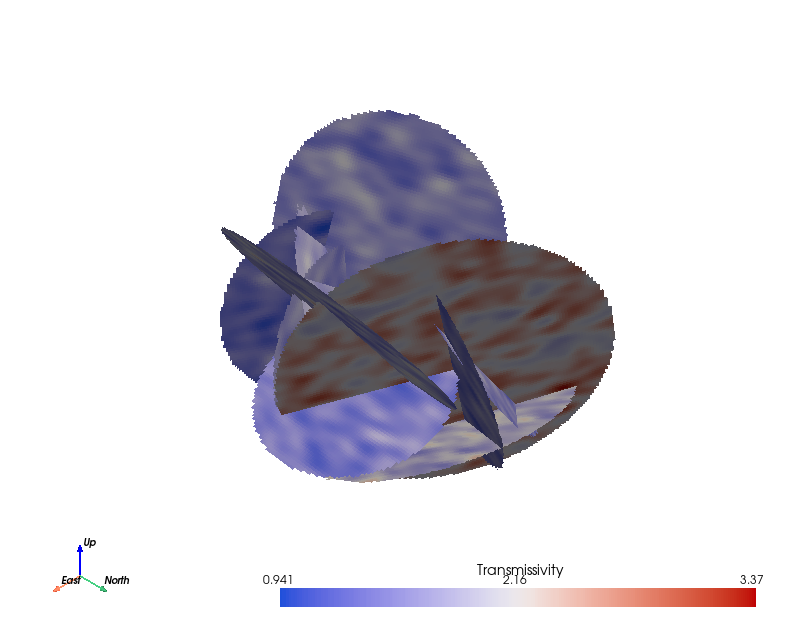

In [15]:
# import require modules from DFN.lab
import dfnlab.RandomGenerator as rng
import dfnlab.ObjectProperties as op
#import the python module math for mathematical operations
import math

# transmissivities are empty properties for now
transmissivities = mat.DFNProperties(fnet)
phySize=[1,1] # physical size of the grid
gSize=[128,128] # grid discretization
for f in fnet: # loop over all fractures
    l = f.getSize() # get the length of the fracture
    crf = rng.CRFGenerator(seed=f.getIndex()) # a correlated random field generator
    crf.setLogNormalDistribution(logmean=1*math.pow(l,2), logstd=0.1) # distribution of values in the CRF
    crf.setGaussianCorrelation(0.05,0.1) # correlation of the CRF
    crf.setGridSize(gSize[0],gSize[1]) # apply grid size
    crf.setPhysicalSize(sizex=phySize[0],sizey=phySize[1]) # apply physical size
    # In this casen the transmissvitiy is a property that is in 2D
    hgrid = op.PropertyGrid2D(physicalsize=phySize,gridsize=gSize,generator=crf)
    # generic object to assign a property to a fracture
    hprop = op.ObjectProperty(hgrid)
    # assign this property to the fracture
    transmissivities.setProperty(f,hprop)
# since transmissivities are here stochastic, they must be generated 
transmissivities.generateAllValues()
# define the transmissivity property as a property of the DFN
# the name "transmissivities" is used to identify the property and cannot be changed
fnet.addProperties("transmissivities", transmissivities)

plot_dfn_hydro(system)